# Makeover Monday: Bike crashes in London

### Import Python tools and Jupyter configuration

In [23]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [24]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
import datetime as dt

In [25]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

In [26]:
today = dt.datetime.today().strftime("%Y-%m-%d")

---

In [27]:
# https://data.world/makeovermonday/2021w31/workspace/file?filename=Bike+Collisions.xlsx
src = pd.read_excel("https://query.data.world/s/tfaspfre5yetduocupcyfbhdawcv6y")

In [28]:
src.columns = src.columns.str.lower().str.replace(" ", "", regex=False)

### Dates

In [29]:
src["year"] = src["date"].dt.year.astype(str)
src["weekday"] = src["date"].dt.day_name()
src["monthname"] = src["date"].dt.month_name()
src["monthday"] = src["date"].dt.strftime("%m-%d")
src["monthyear"] = src["date"].dt.strftime("%m-%Y")

### Times

In [30]:
src["date_clean"] = [d.date() for d in src["date"]]

In [31]:
src["hour"] = pd.to_datetime(src["date"]).dt.hour

### Categorize the time of the incident

In [32]:
def categorize_hours(h):
    if (h > 4) and (h <= 8):
        return "5-8am"
    elif (h > 8) and (h <= 12):
        return "9-noon"
    elif (h > 12) and (h <= 16):
        return "1-4pm"
    elif (h > 16) and (h <= 20):
        return "5-8pm"
    elif (h > 20) and (h <= 24):
        return "9-midnight"
    elif h <= 4:
        return "1-4am"

In [33]:
src["time_period"] = src["hour"].apply(categorize_hours)

---

In [34]:
df = src.copy()

In [42]:
df.head()

,accidentindex,date,borough,ward,latitude,longitude,casualties,severity,url,apiurl,numberofcasualties,numberofvehicles,year,weekday,monthname,monthday,monthyear,date_clean,hour,time_period
0,2019010161545,2019-02-04 19:55:00,Hounslow,Heston Central,51.475300,-0.375342,Cyclist,fatal,https://www.cyclestreets.net/collisions/reports/2019010161545/,https://api.cyclestreets.net/v2/collisions.location?id=2019010161545,1,2,2019,Monday,February,02-04,02-2019,2019-02-04,19,5-8pm
1,2019010191515,2019-07-04 15:09:00,Lambeth,Clapham Town,51.468211,-0.144234,Cyclist,fatal,https://www.cyclestreets.net/collisions/reports/2019010191515/,https://api.cyclestreets.net/v2/collisions.location?id=2019010191515,1,2,2019,Thursday,July,07-04,07-2019,2019-07-04,15,1-4pm
2,2019010209381,2019-10-03 17:05:00,Hillingdon,Northwood,51.612605,-0.434904,"Pedestrian,Cyclist",fatal,https://www.cyclestreets.net/collisions/reports/2019010209381/,https://api.cyclestreets.net/v2/collisions.location?id=2019010209381,2,1,2019,Thursday,October,10-03,10-2019,2019-10-03,17,5-8pm
3,2019010214996,2019-10-30 06:39:00,Lewisham,Rushey Green,51.444015,-0.026135,Cyclist,fatal,https://www.cyclestreets.net/collisions/reports/2019010214996/,https://api.cyclestreets.net/v2/collisions.location?id=2019010214996,1,2,2019,Wednesday,October,10-30,10-2019,2019-10-30,6,5-8am
4,2019010254652,2019-02-09 08:40:00,Camden,West Hampstead,51.550844,-0.191400,Cyclist,fatal,https://www.cyclestreets.net/collisions/reports/2019010254652/,https://api.cyclestreets.net/v2/collisions.location?id=2019010254652,1,1,2019,Saturday,February,02-09,02-2019,2019-02-09,8,5-8am


---

### Wards

In [45]:
wards = df.groupby(["ward", "year"]).agg({"numberofcasualties": "sum"}).reset_index()

In [46]:
wards

,ward,year,numberofcasualties
0,Abbey,2005,11
1,Abbey,2006,6
2,Abbey,2007,7
3,Abbey,2008,10
4,Abbey,2009,9
...,...,...,...
8699,Yiewsley,2015,6
8700,Yiewsley,2016,5
8701,Yiewsley,2017,4
8702,Yiewsley,2018,4


### Boroughs

In [47]:
boroughs = (
    df.groupby(["borough", "year"]).agg({"numberofcasualties": "sum"}).reset_index()
)

In [48]:
boroughs

,borough,year,numberofcasualties
0,Barking and Dagenham,2005,37
1,Barking and Dagenham,2006,39
2,Barking and Dagenham,2007,22
3,Barking and Dagenham,2008,31
4,Barking and Dagenham,2009,30
...,...,...,...
490,Westminster,2015,425
491,Westminster,2016,375
492,Westminster,2017,433
493,Westminster,2018,403


---

### Geography

In [36]:
# via https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

In [37]:
wards = gpd.read_file(
    "data/raw/London-wards-2018/London-wards-2018_ESRI/London_Ward.shp"
)

<AxesSubplot:>

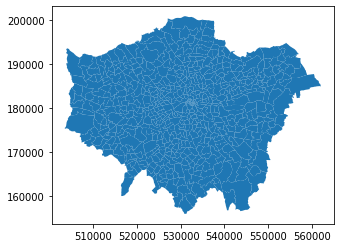

In [38]:
wards.plot()

In [39]:
boroughs = gpd.read_file(
    "data/raw/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
)

<AxesSubplot:>

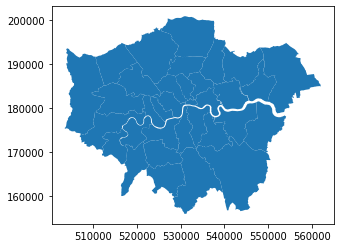

In [40]:
boroughs.plot()